# Data Parameters
Input

- Frames: 5 in 1 out
- Target: 8 stations
- Channels: AirNow, Wind U/V
- Temporal data (Months, Weekdays, Days, Hours)

Model
- See "Architecture"

Result


In [1]:
# file locations
# for libs.plotting
import sys
sys.path.append("/home/mgraca/Workspace/hrrr-smoke-viz")
# for the model checkpoint callback (if enabled)
model_checkpoint_file = '/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/experiment_output/basic_experiments/model.keras'
# where the training data is stored
data_path = "/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/final_input_data/two_years_with_hrrr/"

# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5
EPOCHS = 100
BATCH_SIZE = 32

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

#from libs.sequence import PWWBPyDataset

In [3]:
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "HRRR_COLMD_X_test.npy", "MAIAC_AOD_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "TROPOMI_NO2_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "HRRR_COLMD_X_train.npy", "MAIAC_AOD_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "TROPOMI_NO2_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "HRRR_COLMD_X_valid.npy", "MAIAC_AOD_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy", "TROPOMI_NO2_X_valid.npy"]
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy"]

Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [4]:
''' y is not trimmed, can't use this method
BATCH_SIZE = 32
X_training_files_paths = [f"{data_path + file}" for file in X_train_files]
Y_training_files_paths = f"{data_path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=callbacks
)
'''
X_train = np.stack([np.load(f"{data_path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{data_path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{data_path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{data_path + Y_train_files}")
Y_test = np.load(f"{data_path + Y_test_files}")
Y_valid = np.load(f"{data_path + Y_valid_files}")

In [5]:
X_train_2 = np.load(f"{data_path + "Temporal_Encoding_X_train.npy"}")
X_test_2 = np.load(f"{data_path + "Temporal_Encoding_X_test.npy"}")
X_valid_2 = np.load(f"{data_path + "Temporal_Encoding_X_valid.npy"}")

In [6]:
# 5 frames in, one frame and one station out
# next frame = 0 (:1)
# LA station = 4, Compton = 5
sensors = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 
    'Compton', 'Long Beach Signal Hill', 'Anaheim', 'Glendora - Laurel', 'Mira Loma - Van Buren', 
    'Riverside - Rubidoux', 'Lake Elsinore - W. Flint Street', 'Crestline - Lake Gregory', 
    'Temecula (Lake Skinner)', 'Fontana - Arrow Highway', 'EBAM-2'
]
sensor = {location : i for i, location in enumerate(sensors)}
sensor_names = sensors[:8]

Y_train = Y_train[:, :1, :8].copy()
Y_test = Y_test[:, :1, :8].copy()
Y_valid = Y_valid[:, :1, :8].copy()

# Model Definition

## Architecture

In [7]:
output_frames, output_stations = Y_train.shape[1:]
input_shape_1 = X_train.shape[1:] # (frames, height, width, channels)
input_shape_2 = X_train_2.shape[1:] # (frames, encoded time)

print(
    "Frame data input\n"
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape_1}\n"
    f"Output shape:  ({output_frames}, {output_stations})\n"
)

print(
    "Temporal data input\n"
    f"X_train shape: {X_train_2.shape}\n"
    
    f"X_test shape:  {X_test_2.shape}\n"

    f"X_valid shape: {X_valid_2.shape}\n"

    f"Input shape:   {input_shape_2}\n"
)

Frame data input
X_train shape: (12274, 5, 40, 40, 3)
Y_train shape: (12274, 1, 8)

X_test shape:  (2631, 5, 40, 40, 3)
Y_test shape:  (2631, 1, 8)

X_valid shape: (2630, 5, 40, 40, 3)
Y_valid shape: (2630, 1, 8)

Input shape:   (5, 40, 40, 3)
Output shape:  (1, 8)

Temporal data input
X_train shape: (12274, 5, 74)
X_test shape:  (2631, 5, 74)
X_valid shape: (2630, 5, 74)
Input shape:   (5, 74)



In [8]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import Flatten 
from keras.layers import Input

tf.keras.backend.set_image_data_format('channels_last')

spatiotemporal_input = Input(shape=input_shape_1)
temporal_encoding_input = Input(shape=input_shape_2)
temporal_block = Flatten()(temporal_encoding_input)

x = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding='same', return_sequences=True)(spatiotemporal_input)
x = ConvLSTM2D(filters=30, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
x = Conv3D(filters=15, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = Conv3D(filters=1, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
conv_block = Flatten()(x)

x = Concatenate()([conv_block, temporal_block])
x = Dense(units=output_stations * output_frames, activation='relu')(x)
next_frame_pred = Reshape((output_frames, output_stations))(x)

model = Model(
    inputs=[spatiotemporal_input, temporal_encoding_input],
    outputs=next_frame_pred
)
model.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.004)
)
model.summary()

2025-08-02 16:36:21.771727: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-02 16:36:21.780327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754177781.791375   33445 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754177781.795057   33445 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-02 16:36:21.805890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 40, 40, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 5, 40, 40, │      9,780 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 5, 40, 40, │     48,720 │ conv_lstm2d[0][0] │
│ (ConvLSTM2D)        │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 5, 40, 40, │     12,165 │ conv_lstm2d_1[0]… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 5, 40, 40, │        406 │ conv3d[0][0]      │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5, 74)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8000)      │          0 │ conv3d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 370)       │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8370)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │     66,968 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 8)      │          0 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 138,039 (539.21 KB)

 Trainable params: 138,039 (539.21 KB)

 Non-trainable params: 0 (0.00 B)

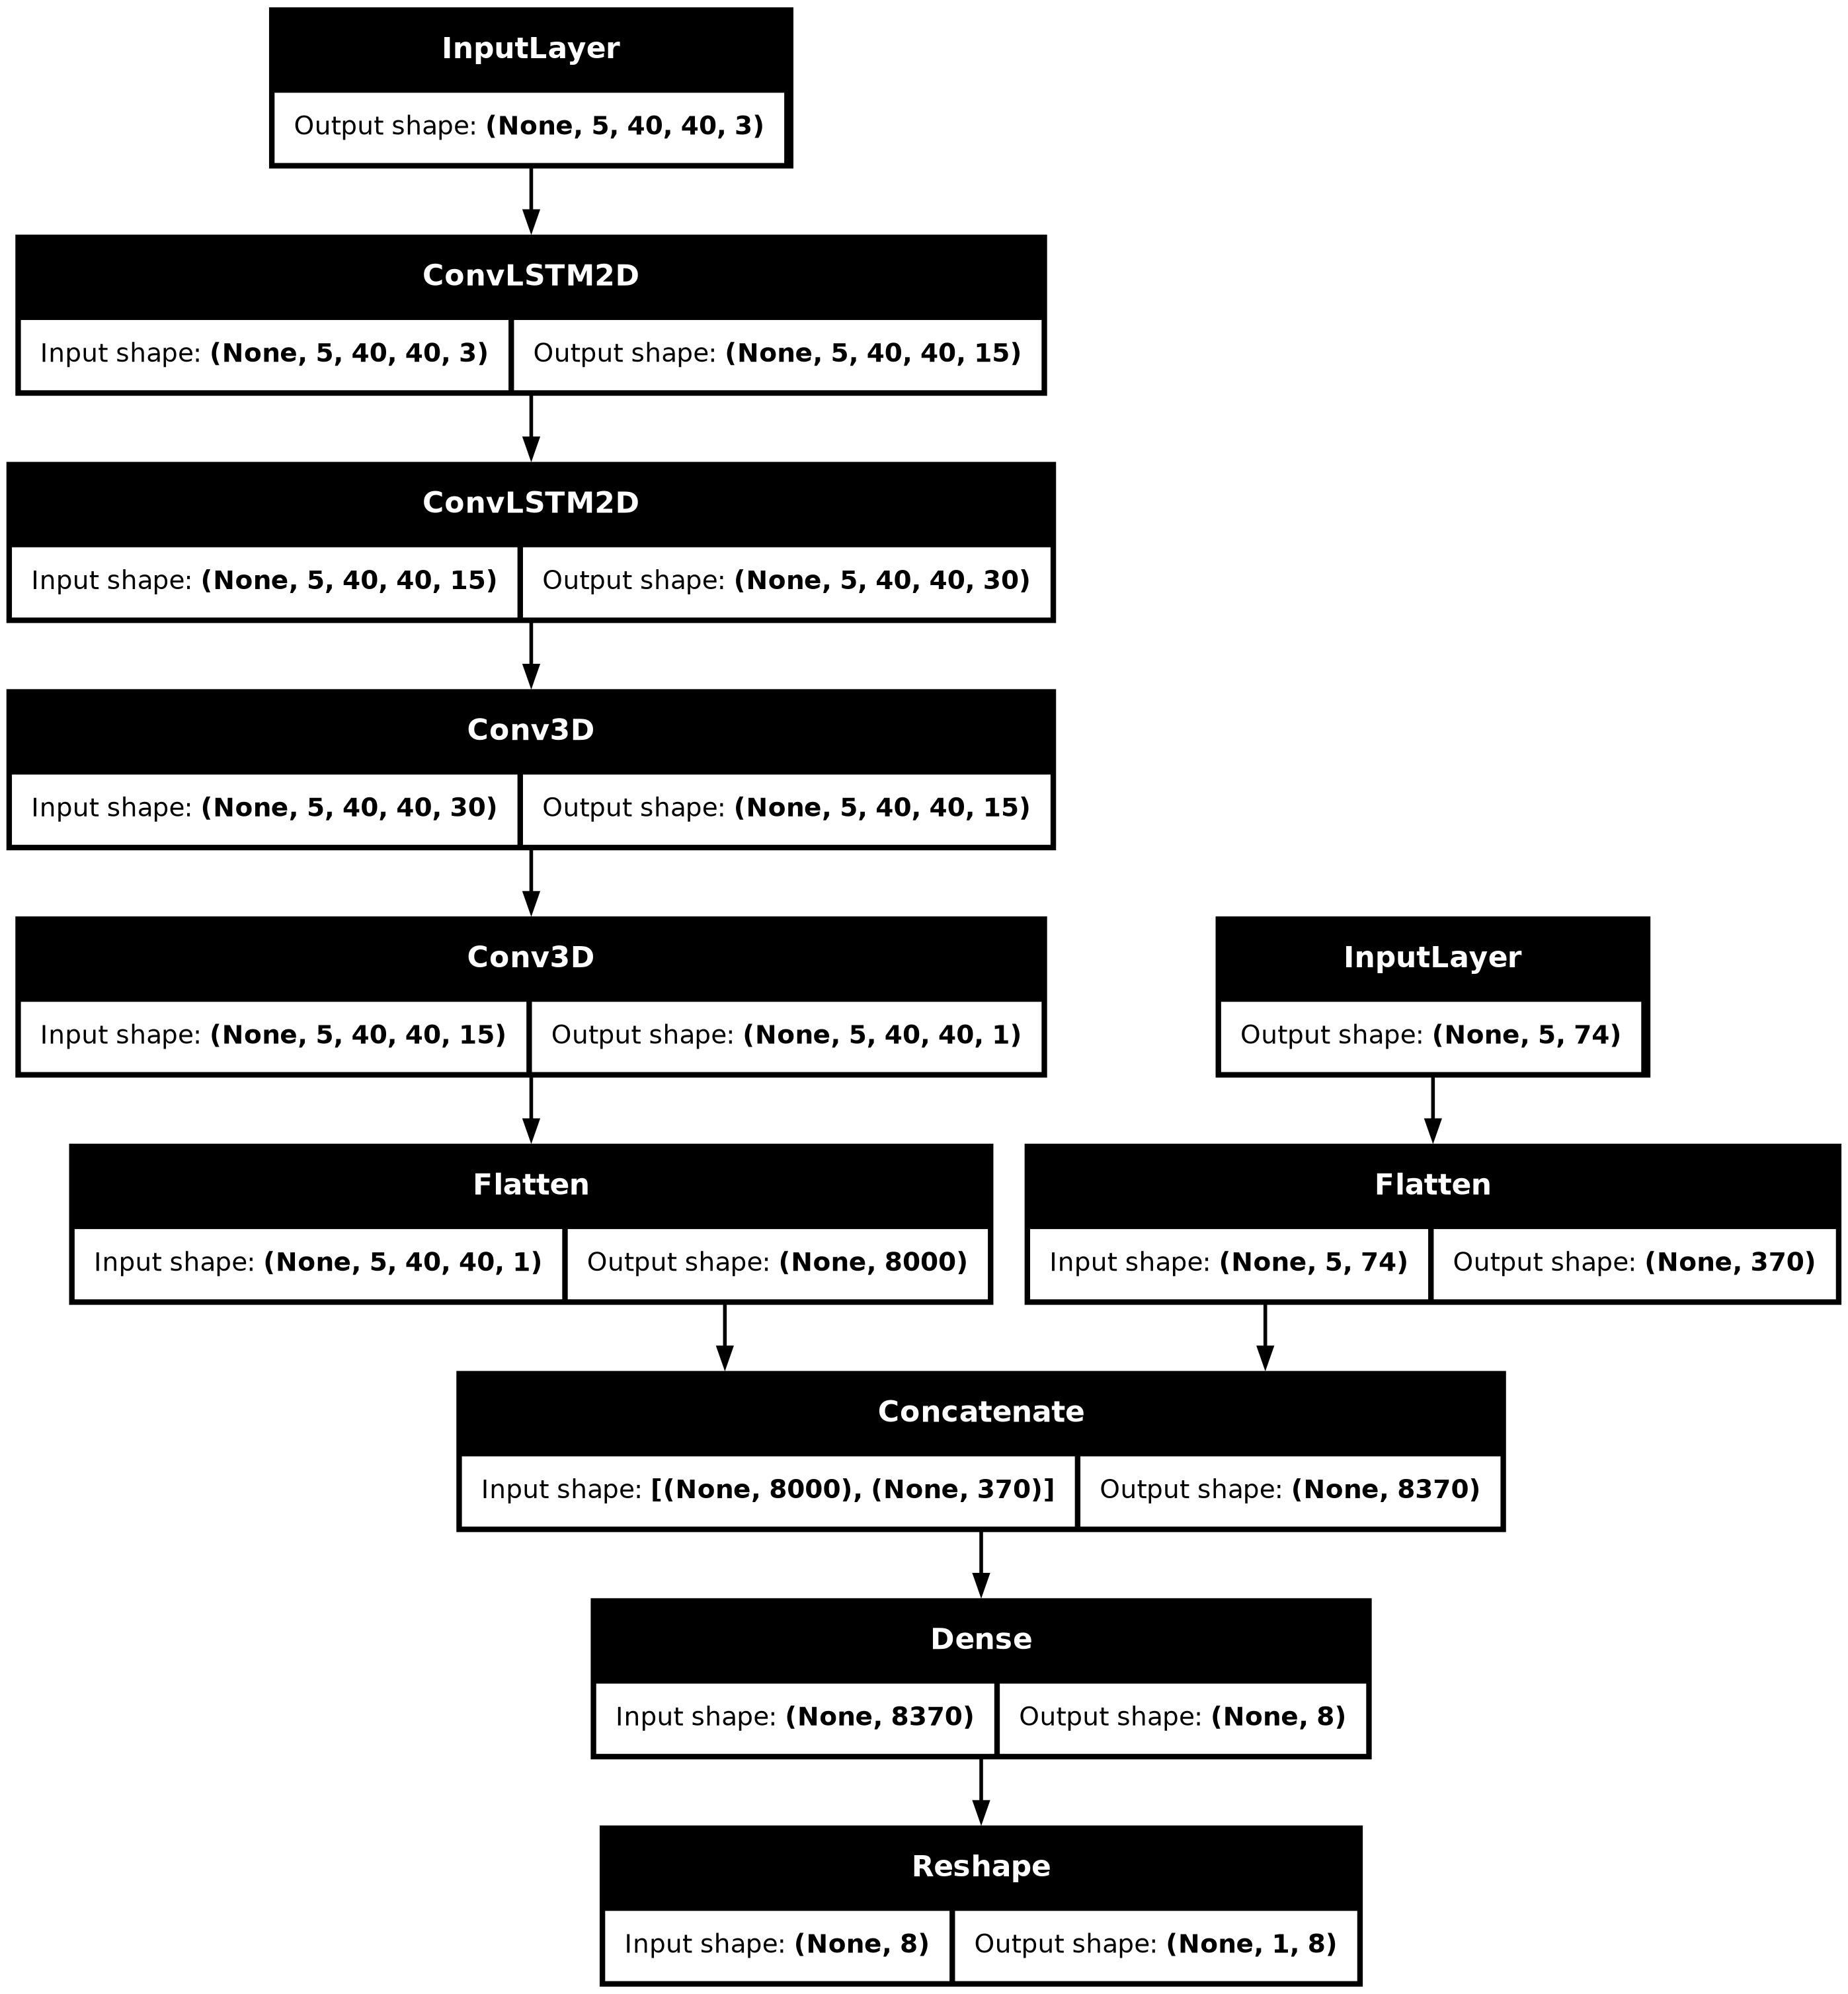

In [9]:
keras.utils.plot_model(model, "model_graph.png", show_shapes=True)

## Callbacks

In [10]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)
tensorboard_callback = TensorBoard(run_logdir, histogram_freq=1)
#gradient_logging_callback = GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))

# model checkpoint callback setup
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# lr scheduling callback setup
lr_scheduling_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
)

# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
)

# define list of callbacks we're gonna use
callbacks = [
    #early_stopping_callback,
    model_checkpoint_callback,
    #lr_scheduling_callback,
    #tensorboard_callback,
    #gradient_logging_callback
]

## Training

In [11]:
history = model.fit(
    x=[X_train, X_train_2],
    y=Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([X_valid, X_valid_2], Y_valid),
    callbacks=callbacks
)

Epoch 1/100


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1754177787.204380   33519 service.cc:148] XLA service 0x78641400b620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754177787.204417   33519 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-08-02 16:36:27.266690: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754177787.543495   33519 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-08-02 16:36:28.019380: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2

  3/384 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 9.0060

I0000 00:00:1754177790.048840   33519 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5.7684

2025-08-02 16:36:50.959837: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[18,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-02 16:36:51.090821: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[18,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 5.7638

2025-08-02 16:36:55.465697: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[6,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-02 16:36:55.519703: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[6,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

384/384 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - loss: 5.7593 - val_loss: 2.8857
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.6825 - val_loss: 2.3846
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 2.2890 - val_loss: 2.2437
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.0923 - val_loss: 2.0594
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 1.9363 - val_loss: 1.9644
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 1.8037 - val_loss: 1.9381
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 1.7038 - val_loss: 1.8644
Epoch 8/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 1.6253 - val_loss: 1.9037
Epoch 9/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 1.5663 - val_loss: 1.6741
Epoch 10/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 1.4938 - val_loss: 1.6433
Epoch 11/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 1.4492 - val_loss: 1.5796
Epoch 12/100
384/384 ━━━━━━━━━━

# Model Evaluation


Evaluating model


2025-08-02 17:15:23.605583: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[7,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-08-02 17:15:23.658286: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[7,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

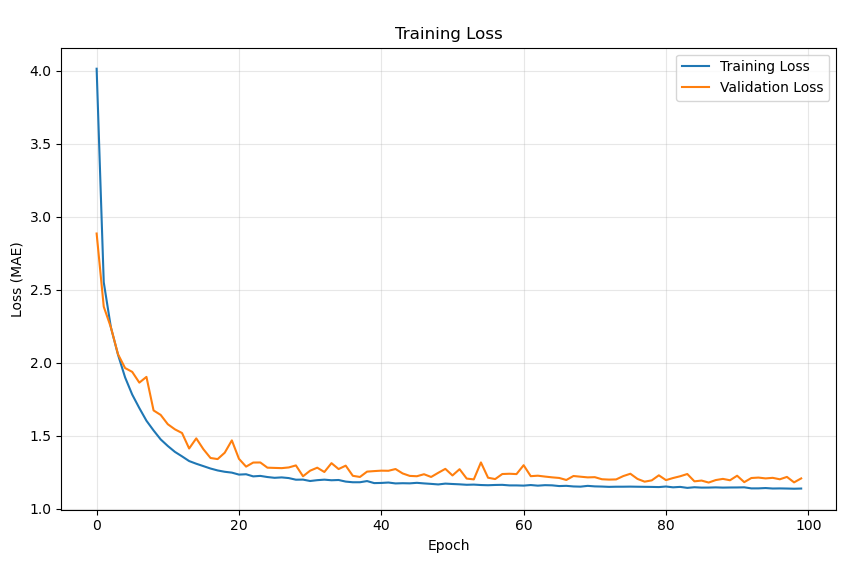

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
#model = keras.saving.load_model(model_checkpoint_file)
y_pred = model.predict([X_test, X_test_2], verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
print(Y_test.shape, y_pred.shape)

(2631, 1, 8) (2631, 1, 8)


In [16]:
from libs.plotting import *
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error as mape

# avg error of each station across all frames
results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        mape(np.squeeze(Y_test[:-1]), np.squeeze(Y_test[1:]))*100,
        mape(np.squeeze(Y_test), np.squeeze(y_pred))*100,
        mape(np.squeeze(Y_test[:-1]), np.squeeze(y_pred[1:]))*100,
    ],
    [
        r2_score(Y_test[:-1], Y_test[1:]),
        r2_score(Y_test, y_pred),
        r2_score(Y_test[:-1], y_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.030924,1.914136,1.217513
NRMSE,18.326171,17.277076,10.986306
MAE,1.373517,1.306999,0.857383
MAPE,18.439053,18.874356,12.935368
R2,0.887086,0.899729,0.959420


In [17]:
# avg pm2.5 over the entire area vs avg prediction over entire area
# basically all stations merged into 1 value instead of average error on each particular station
# difference with above: calculate errors of each station, THEN average VS calculate average PM2.5, THEN calculate error
y_pred_avg = np.mean(y_pred, axis=-1)
Y_test_avg = np.mean(Y_test, axis=-1)

results = [
    [
        rmse(Y_test_avg[1:], Y_test_avg[:-1]), 
        rmse(y_pred_avg, Y_test_avg),
        rmse(y_pred_avg[1:], Y_test_avg[:-1]),
    ],
    [
        nrmse(Y_test_avg[1:], Y_test_avg[:-1]),
        nrmse(y_pred_avg, Y_test_avg),        
        nrmse(y_pred_avg[1:], Y_test_avg[:-1]),

    ],
    [        
        mae(Y_test_avg[1:], Y_test_avg[:-1]),
        mae(y_pred_avg, Y_test_avg),
        mae(y_pred_avg[1:], Y_test_avg[:-1]),
    ],
    [
        mape(np.squeeze(Y_test_avg[:-1]), np.squeeze(Y_test_avg[1:]))*100,
        mape(np.squeeze(Y_test_avg), np.squeeze(y_pred_avg))*100,
        mape(np.squeeze(Y_test_avg[:-1]), np.squeeze(y_pred_avg[1:]))*100,
    ],
    [
        r2_score(Y_test_avg[:-1], Y_test_avg[1:]),
        r2_score(Y_test_avg, y_pred_avg),
        r2_score(Y_test_avg[:-1], y_pred_avg[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,1.030916,0.802350,0.664378
NRMSE,9.302540,7.242046,5.995059
MAE,0.767576,0.591586,0.504511
MAPE,7.460947,5.858215,5.159336
R2,0.935881,0.961203,0.973370


In [18]:
'''
# first-frame error
results = [
    [
        rmse(Y_test[1:, 0], Y_test[:-1, 0]), 
        rmse(y_pred[:, 0], Y_test[:, 0]),
        rmse(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        nrmse(Y_test[1:, 0], Y_test[:-1, 0]),
        nrmse(y_pred[:, 0], Y_test[:, 0]),        
        nrmse(y_pred[1:, 0], Y_test[:-1, 0]),

    ],
    [        
        mae(Y_test[1:, 0], Y_test[:-1, 0]),
        mae(y_pred[:, 0], Y_test[:, 0]),
        mae(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        mape(np.squeeze(Y_test[:-1, 0]), np.squeeze(Y_test[1:, 0]))*100,
        mape(np.squeeze(Y_test[:, 0]), np.squeeze(y_pred[:, 0]))*100,
        mape(np.squeeze(Y_test[:-1, 0]), np.squeeze(y_pred[1:, 0]))*100,
    ],
    [
        r2_score(Y_test[:-1, 0], Y_test[1:, 0]),
        r2_score(Y_test[:, 0], y_pred[:, 0]),
        r2_score(Y_test[:-1, 0], y_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)
''';

In [19]:
# first frame LA error
results = [
    [
        rmse(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]), 
        rmse(y_pred[:, 0, 4], Y_test[:, 0, 4]),
        rmse(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),
    ],
    [
        nrmse(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]),
        nrmse(y_pred[:, 0, 4], Y_test[:, 0, 4]),        
        nrmse(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),

    ],
    [        
        mae(Y_test[1:, 0, 4], Y_test[:-1, 0, 4]),
        mae(y_pred[:, 0, 4], Y_test[:, 0, 4]),
        mae(y_pred[1:, 0, 4], Y_test[:-1, 0, 4]),
    ],
    [
        mape(np.squeeze(Y_test[:-1, 0, 4]), np.squeeze(Y_test[1:, 0, 4]))*100,
        mape(np.squeeze(Y_test[:, 0, 4]), np.squeeze(y_pred[:, 0, 4]))*100,
        mape(np.squeeze(Y_test[:-1, 0, 4]), np.squeeze(y_pred[1:, 0, 4]))*100,
    ],
    [
        r2_score(Y_test[:-1, 0, 4], Y_test[1:, 0, 4]),
        r2_score(Y_test[:, 0, 4], y_pred[:, 0, 4]),
        r2_score(Y_test[:-1, 0, 4], y_pred[1:, 0, 4]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.024425,1.922911,1.327775
NRMSE,14.480573,13.758032,9.497479
MAE,1.420499,1.316506,0.927463
MAPE,10.915003,9.665217,6.991485
R2,0.898886,0.908816,0.956503


In [20]:
# first frame, error breakdown for every sensor, nrmse
results = [
    *[
        [
            nrmse(Y_test[1:, 0, i], Y_test[:-1, 0, i]),
            nrmse(y_pred[:, 0, i], Y_test[:, 0, i]),
            nrmse(y_pred[1:, 0, i], Y_test[:-1, 0, i])
        ]
        for i in range(len(sensor_names))
    ]
]
df = pd.DataFrame(
    results, 
    columns=['Baseline NRMSE', 'Model NRMSE', 'Model NRMSE Shifted'], 
    index=sensor_names
)
display(df)

,Baseline NRMSE,Model NRMSE,Model NRMSE Shifted
Simi Valley - Cochran Street,19.049932,18.594118,10.404026
Reseda,20.034834,20.640330,14.195174
Santa Clarita,15.806760,14.813342,7.776896
North Holywood,15.910362,14.205688,9.034011
Los Angeles - N. Main Street,14.480573,13.758032,9.497479
Compton,21.827155,20.563730,14.321203
Long Beach Signal Hill,22.377316,20.910713,11.462242
Anaheim,16.540607,14.942359,9.272755


In [21]:
'''
plot_frame_by_frame_rmse(y_pred, Y_test)
print_detailed_frame_stats(y_pred, Y_test, sensor_names)
''';

# Plots

## Snapshot plots - first frame

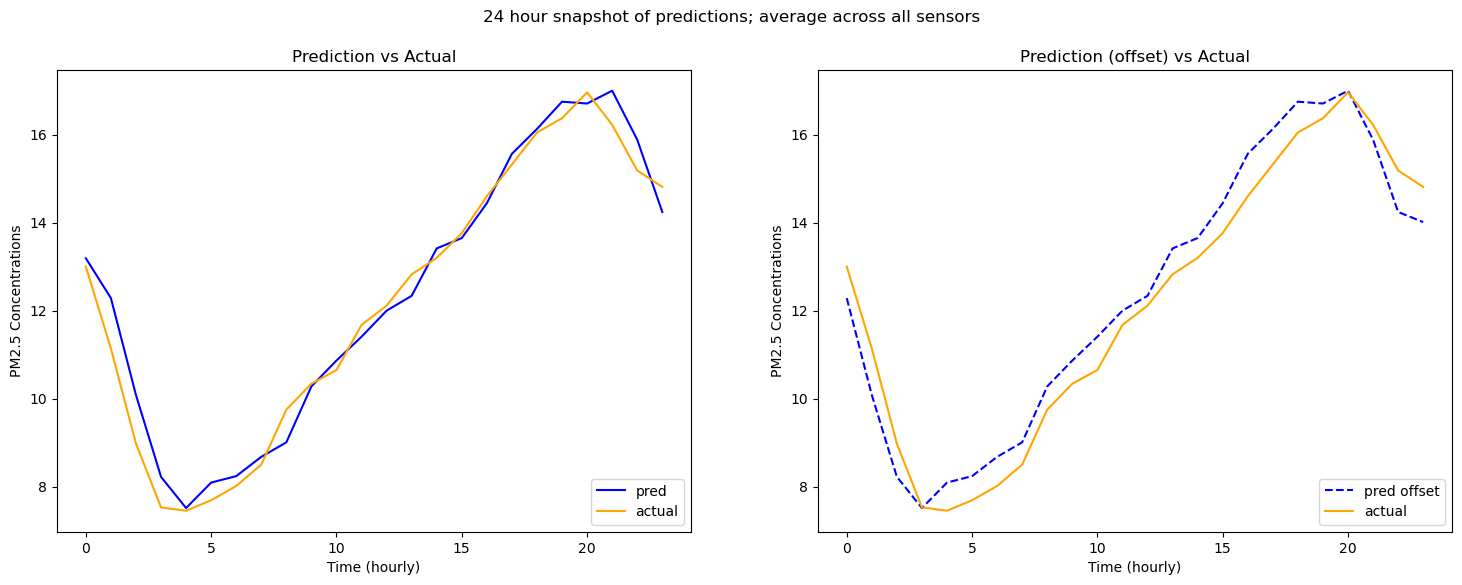

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("24 hour snapshot of predictions; average across all sensors")

axes[0].plot(y_pred_avg[1000:1024, 0], color='blue', label='pred')
axes[0].plot(Y_test_avg[1000:1024, 0], color='orange', label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].legend(loc="lower right")
axes[0].set_title("Prediction vs Actual")

axes[1].plot(y_pred_avg[1001:1025, 0], color='blue', linestyle='--', label='pred offset')
axes[1].plot(Y_test_avg[1000:1024, 0], color='orange', label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].legend(loc="lower right")
axes[1].set_title("Prediction (offset) vs Actual")

plt.show()

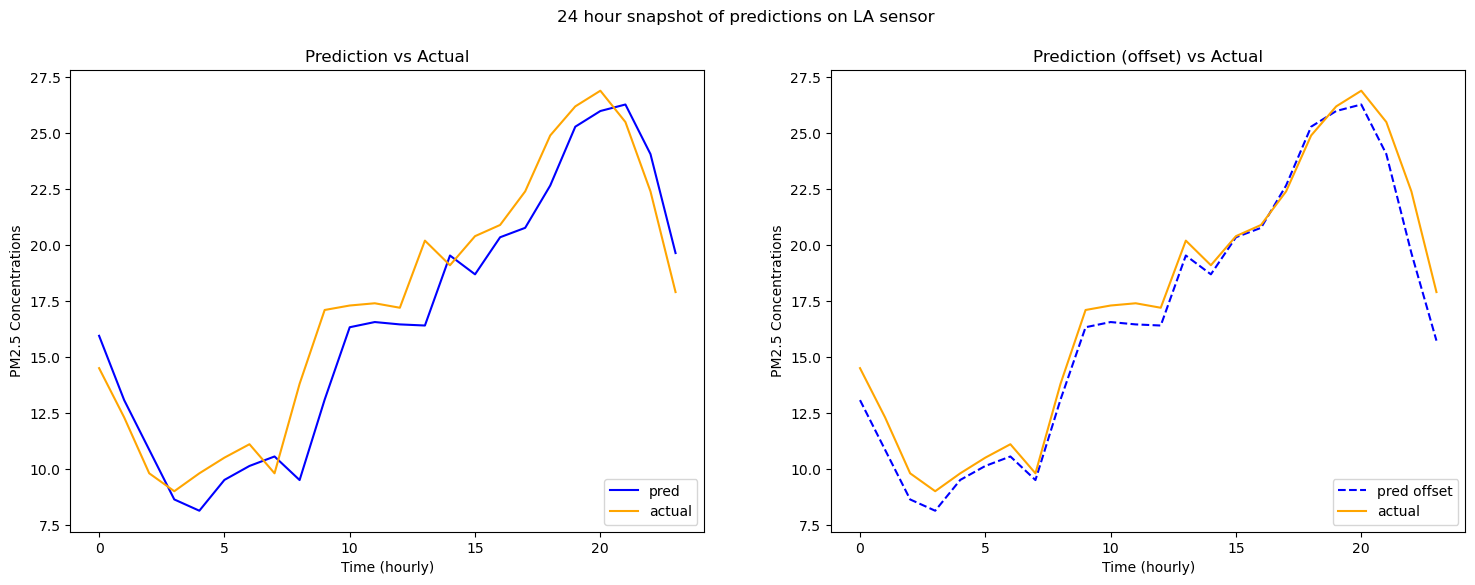

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("24 hour snapshot of predictions on LA sensor")

axes[0].plot(y_pred[1000:1024, 0, 4], color='blue', label='pred')
axes[0].plot(Y_test[1000:1024, 0, 4], color='orange', label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].legend(loc="lower right")
axes[0].set_title("Prediction vs Actual")

axes[1].plot(y_pred[1001:1025, 0, 4], color='blue', linestyle='--', label='pred offset')
axes[1].plot(Y_test[1000:1024, 0, 4], color='orange', label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].legend(loc="lower right")
axes[1].set_title("Prediction (offset) vs Actual")

plt.show()

[]

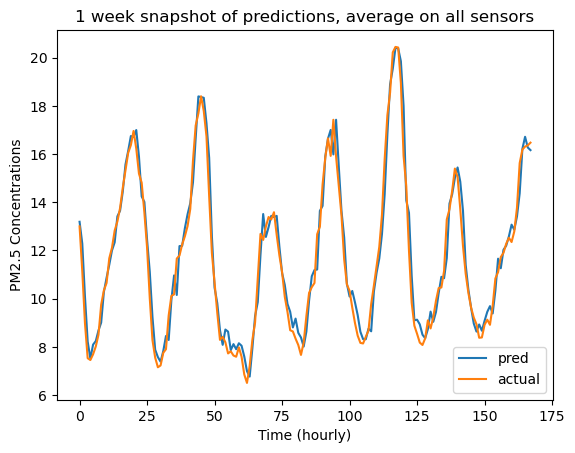

In [24]:
plt.plot(y_pred_avg[1000:1168, 0], label='pred')
plt.plot(Y_test_avg[1000:1168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions, average on all sensors")
plt.legend(loc="lower right")
plt.plot()

[]

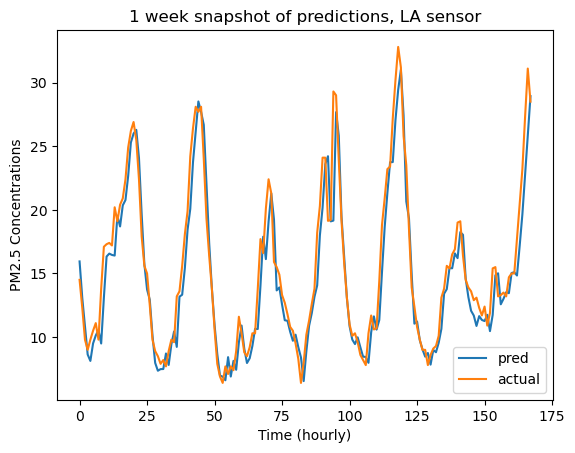

In [25]:
plt.plot(y_pred[1000:1168, 0, 4], label='pred')
plt.plot(Y_test[1000:1168, 0, 4], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions, LA sensor")
plt.legend(loc="lower right")
plt.plot()

In [26]:
# best/worst if all stations are averaged into one
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

for i in range(len(y_pred) - 168):
    err = nrmse(y_pred_avg[i:i+168, 0], Y_test_avg[i:i+168, 0])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i
print(best_idx, worst_idx)

1397 2180


In [27]:
dates = pd.date_range(START_DATE, END_DATE, freq='h')
y_test_start_idx = len(Y_valid)
y_test_end_idx = len(Y_valid) + len(Y_test)
print(dates[y_test_start_idx], dates[y_test_end_idx])

2023-03-20 14:00:00 2023-07-08 05:00:00


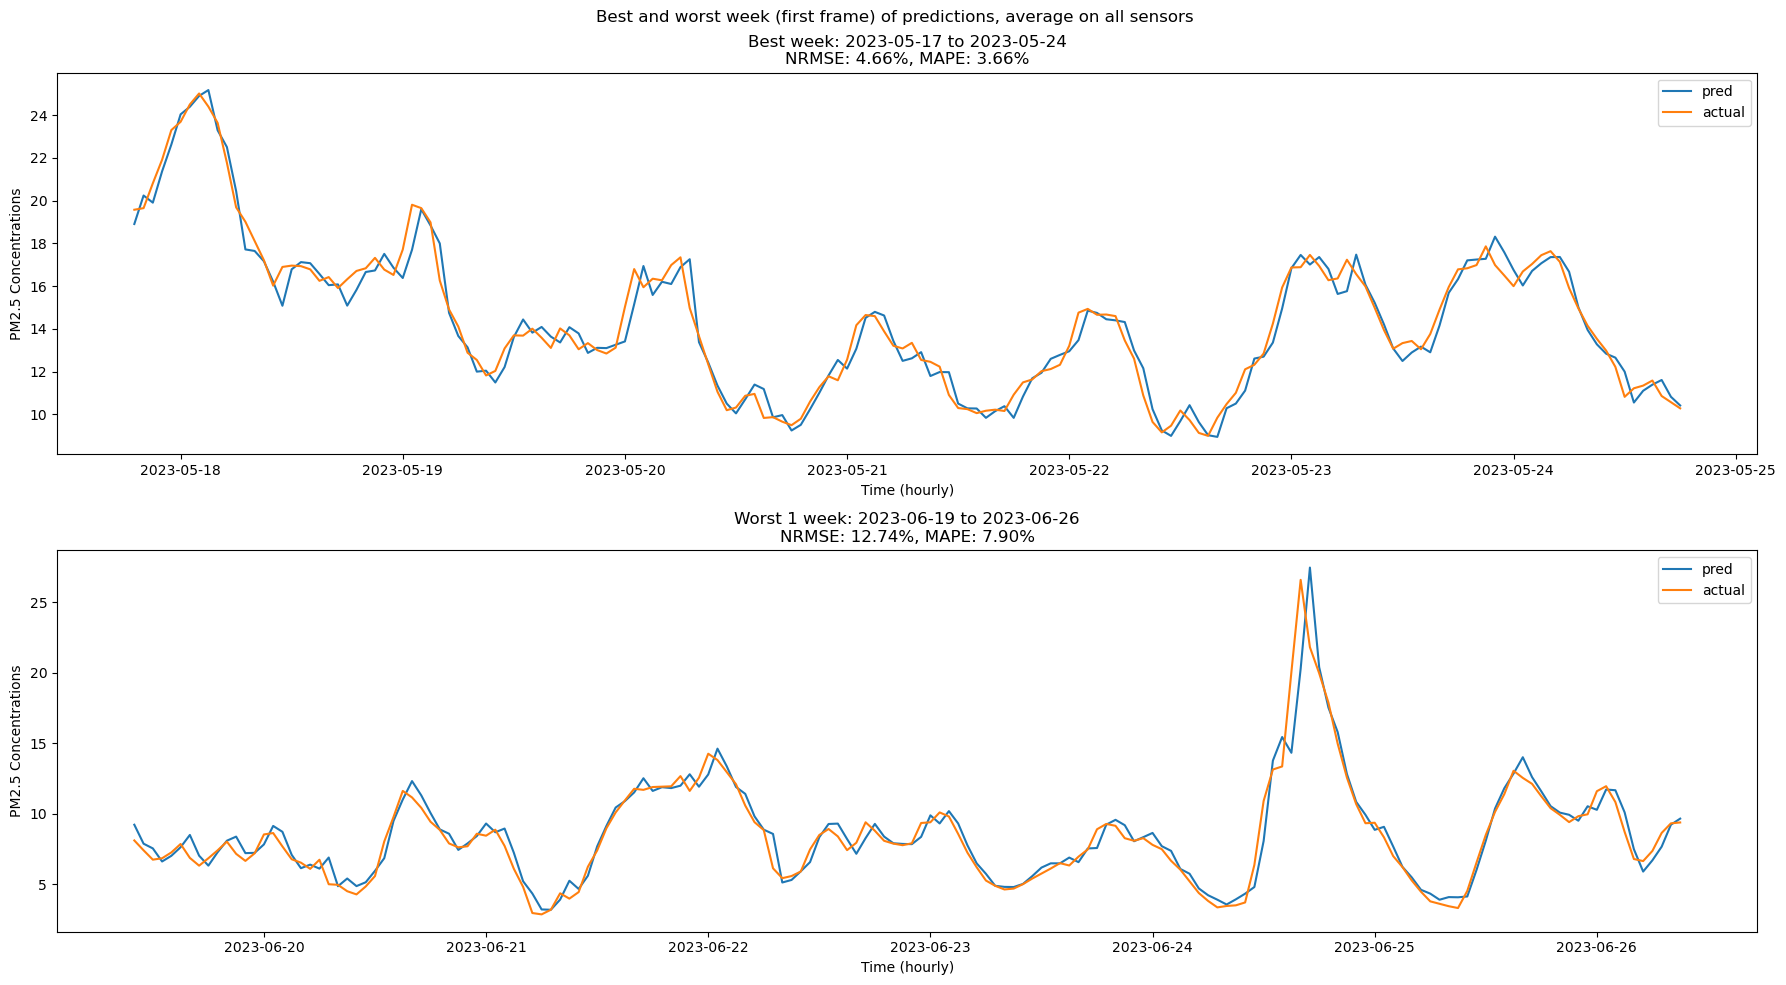

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions, average on all sensors')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    y_pred_avg[best_idx:best_idx+168, 0],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    Y_test_avg[best_idx:best_idx+168, 0],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {best_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test_avg[best_idx : best_idx + 168]), 
        np.squeeze(y_pred_avg[best_idx : best_idx + 168])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week
axes[1].plot(
    dates[y_test_start_idx + worst_idx : y_test_start_idx + worst_idx + 168],
    y_pred_avg[worst_idx:worst_idx+168, 0], 
    label='pred'
)
axes[1].plot(
    dates[y_test_start_idx + worst_idx : y_test_start_idx + worst_idx + 168],
    Y_test_avg[worst_idx:worst_idx+168, 0],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week: {dates[y_test_start_idx + worst_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {worst_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test_avg[worst_idx : worst_idx + 168]), 
        np.squeeze(y_pred_avg[worst_idx : worst_idx + 168])
    )*100:.2f}%"
)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [29]:
# best/worst of an individual sensor
best_week_sensor = float('inf')
worst_week_sensor = float('-inf')
best_sensor, worst_sensor = -1, -1
best_idx_sensor, worst_idx_sensor = 0, 0
for i in range(len(y_pred) - 168):
    for j in range(len(sensor_names)):
        err = nrmse(y_pred[i:i+168, 0, j], Y_test[i:i+168, 0, j])
        if err < best_week_sensor:
            best_week_sensor = err
            best_idx_sensor = i
            best_sensor = j
        if err > worst_week_sensor:
            worst_week_sensor = err
            worst_idx_sensor = i
            worst_sensor = j
print(best_idx_sensor, best_sensor, worst_idx_sensor, worst_sensor)

88 4 788 1


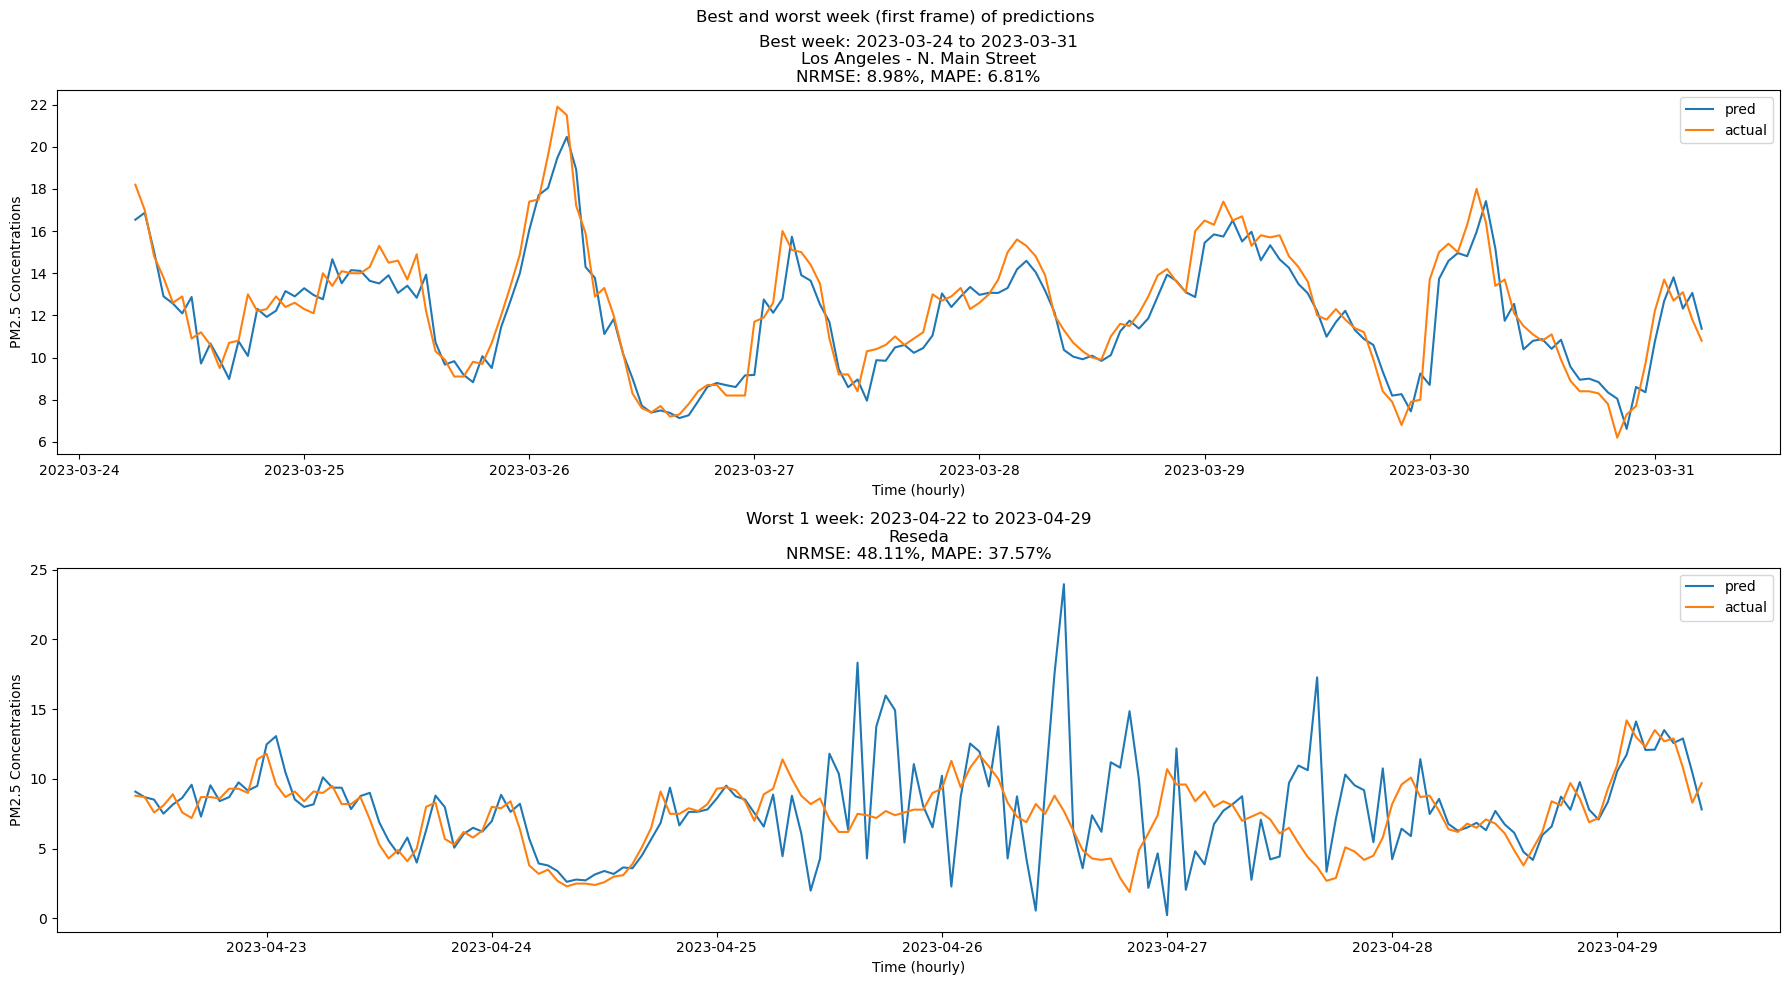

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx_sensor : y_test_start_idx + best_idx_sensor + 168],
    y_pred[best_idx_sensor:best_idx_sensor+168, 0, best_sensor],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx_sensor : y_test_start_idx + best_idx_sensor + 168],
    Y_test[best_idx_sensor:best_idx_sensor+168, 0, best_sensor],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx_sensor].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx_sensor + 168].strftime('%Y-%m-%d')}\n"
    f"{sensor_names[best_sensor]}\n"
    f"NRMSE: {best_week_sensor:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[best_idx_sensor : best_idx_sensor + 168, 0, best_sensor]), 
        np.squeeze(y_pred[best_idx_sensor : best_idx_sensor + 168, 0, best_sensor])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week
axes[1].plot(
    dates[y_test_start_idx + worst_idx_sensor : y_test_start_idx + worst_idx_sensor + 168],
    y_pred[worst_idx_sensor:worst_idx_sensor+168, 0, worst_sensor], 
    label='pred'
)
axes[1].plot(
    dates[y_test_start_idx + worst_idx_sensor : y_test_start_idx + worst_idx_sensor + 168],
    Y_test[worst_idx_sensor:worst_idx_sensor+168, 0, worst_sensor],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week: {dates[y_test_start_idx + worst_idx_sensor].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx_sensor + 168].strftime('%Y-%m-%d')}\n"
    f"{sensor_names[worst_sensor]}\n"
    f"NRMSE: {worst_week_sensor:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[worst_idx_sensor : worst_idx_sensor + 168, 0, worst_sensor]), 
        np.squeeze(y_pred[worst_idx_sensor: worst_idx_sensor + 168, 0, worst_sensor])
    )*100:.2f}%"
)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()